# **Laboratorio: implementación de un clasificador de Bayes Gaussiano**

En este laboratorio implementaremos un clasificador de Bayes Gaussiano. Para ello, recordemos brevemente que un clasificador de Bayes  es un clasificador que usa el teorema de Bayes para estimar la probabilidad de que una observación $x$ pertenezca a la clase $c$:

$$p(c|X) = p(c)\frac{p(x|c)}{p(x)}$$

En el clasificador de Bayes, dada una observación $x$, la clase asignada a esta observación viene de aplicar la regla MAP (maximum a posteriori):

$$\hat c=\text{argmax}_c p(c)\frac{p(x|c)}{p(x)}.$$

Debido a que el término $p(x)$ no depende de $c$, lo podemos quitar de la expresión, quedando:
$$\hat c=\text{argmax}_c p(c)p(x|c).$$


Para dos clases, la regla de decisión del clasificador de Bayes se realiza de la siguiente manera. Sean $c_1$ y $c_2$ las dos posibles clases de que puede tomar la observación del vector $X$, y sean $p(c_1)$ y $p(c_2)$ las probabilidades a priori de estas clases. Decimos que la observación $x$ es clase 1 si:
$$p(c_1|x) > p(c_2|x),$$
es decir,
$$p(x|c_1) p(c_1) > p(x|c_2) p(c_2).$$

Y es clase 2 si se cumple lo contrario. Es decir:
$$p(x|c_1) p(c_1) < p(x|c_2) p(c_2).$$

En el clasificador de Bayes **Gaussiano** se asume que $p(x|c)$, para cada $c$, sigue una distribución Gaussiana. Es decir, por cada clase, tenemos una función de densidad Gaussiana potencialmente diferente.




# **Contexto del problema**

Uno de lo cánceres más comunes entre la población femenina es el cáncer de seno. Éste ocurre cuando las células normales mutan y se transforman en células cancerígenas. Esta transformación puede ser evaluada a través de procedimientos en los que se extraen muestras que se observan bajo el microscopio. Se ha mostrado que en etapas tempranas el núcleo de las células provenientes de los tumores cambia su morfología, permitiendo predecir el desarrollo del cáncer (Narasimha et al., 2013).

En el presente laboratorio se va a encontrar un clasificador de bayes gaussiano para predecir si las células provenientes de un tumor están en proceso de mutación carcinogénica o no. Es decir, diseñaremos un modelo para clasificación, la cual es una tarea que hace parte del paradigma de aprendizaje supervisado en machine learning. El objetivo es encontrar una frontera que parta el espacio en dos regiones: una asociada a las observaciones que son consideradas como malignas y otra región asociada a las observaciones que son concideradas como benignas y que dicha frontera esté dada por los datos y sus probabilidades.

Para entrenar el modelo usaremos una base de datos que consta de 469 muestras obtenidas de dos tipos de pacientes: aquellas que desarrollaron cáncer de seno y las que no. Clasificaremos dicha aparición a partir de dos características que se extraen las imágenes: el **radio promedio** (*radius_mean*) y **suavidad promedio** (*smoothness_mean*) de los núcleos de las células. Esta última medida hace referencia a un índice de variación local del radio en un mismo núcleo, por lo que ante menor índice de suavidad, más redondo será el núcleo. Estas medidas se toman a partir de una imagen del tejido, como se muestra en la Figura 1.


<center> Figura 1. Muestras de núcleos celulares de biopsias de tumores de seno, los núcleos pequeños y redondos proceden de muestras no-cancerígenas (Narasimha et al., 2013). </center>

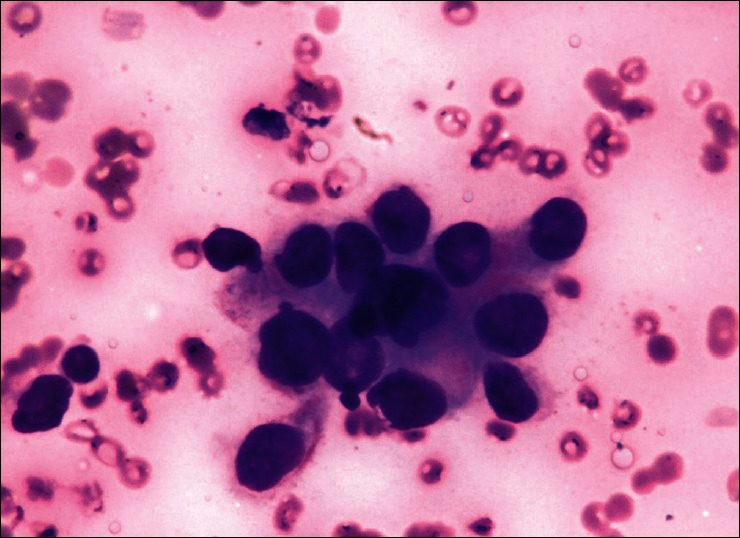

> Narasimha, A., Vasavi, B., & Kumar, H. M. (2013). Significance of nuclear morphometry in benign and malignant breast aspirates. _International Journal of Applied and Basic Medical Research_, 3(1), 22.


## **Implementación del clasificador**

En primer lugar, importamos las librerias necesarias:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Posteriormente, cargamos los datos usando *read_csv* de pandas, los dividimos en las características $X$ y el pronóstico $y$ y los convertimos a arrays de NumPy.

In [ ]:
datos = pd.read_csv("Breast_Cancer_Train_Norm.csv",index_col=0)

X = datos.drop("pronostic",axis=1).to_numpy()
y = datos["pronostic"].to_numpy()

A continuación, visualizamos los datos:

In [ ]:
fig,ax = plt.subplots()
scatter = ax.scatter(X[:,0],X[:,1],c = y)
ax.grid()
ax.set_xlabel("Radius mean")
ax.set_ylabel("Smoothness mean")
ax.set_title("Características y pronóstico")
legend1 = ax.legend(*scatter.legend_elements(), title="Pronóstico")
ax.add_artist(legend1)
plt.show()

En este problema, vamos a asumir que la probabilidad a priori de cada clase es de 0.5. Es decir, el 50% de las células son cancerígenas y el otro 50% no lo son.

Dado que vamos a trabajar con un clasificador de bayes gaussiano, asumimos que los datos tienen una distribución normal dada por la siguiente ecuación:

$$p(x|c_i) = \frac{1}{\sqrt{det(Q_c)}}\frac{1}{(2 \pi)^{n/2}}e^{-\frac{1}{2} (x - \mu_c)^TQ_c^{-1}(x- \mu_c)}$$

Donde $Q_c$ es la matriz de covarianza de los datos pertenecientes a la clase $c$ y $\mu_c$ es el promedio de los datos pertenecientes a la clase $c$ para cada característica. Usando esta densidad de probabilidad por cada clase, ya seremos capaces de aplicar la regla MAP como se describió arriba.

Los modelos de machine learning más utilizados hoy en día se encuentran en librerias populares como scikit-learn, tensorflow y pytorch. Estos métodos están basados en clases de Python y proveen un "esqueleto" que el usuario puede iniciar y usar según sus necesidades de una forma fácil y ordenada. Estos métodos normalmente tienen 2 funciones para facilitar la interacción con el usuario: "fit" para entrenar el modelo y "predict" para realizar una predicción sobre los datos suministrados. A continuación definiremos **nosotros mismos manualmente** la forma de constuir un clasificador de Bayes Gaussiano:

In [ ]:
class Clasificador_Bayes_Gausiano():
    """
    Aquí implementaremos el clasificador de bayes gaussiano.
    """

    def __init__(self, a_priori):
        """
        Inicializamos los parámetros que necesitará el clasificador. En este caso, las probabilidades a priori.
        """
        self.matrices_covarianza = None
        self.vectores_medias = None
        self.n = None
        self.prioris = a_priori

    def obtener_probabilidad(self,X):
        """
        Definimos la función que nos permitirá obtener la probabilidad de que un dato pertenezca a las clases. Es decir, todas las probabilidades p(X|C_i)
        """
        probabilidades = []
        for i in range(len(self.prioris)):
            det = np.linalg.det(self.matrices_covarianza[i])
            inv = np.linalg.inv(self.matrices_covarianza[i])
            probabilidad = self.prioris[i]*np.exp(-0.5*(X-self.vectores_medias[i]).T@inv@(X-self.vectores_medias[i]))/(np.sqrt(det)*(2*np.pi)**(self.n/2))
            probabilidades.append(probabilidad*self.prioris[i])
        return probabilidades

    def fit(self,X,y):
        """
        Definimos la función que nos permitirá entrenar el clasificador. En este caso, necesitamos calcular las matrices de covarianza y los vectores de medias. Esta función depende de los datos X y las etiquetas Y.
        """
        matrices_covarianza = []
        vectores_medias = []
        for i in np.unique(y):
            X_clase = X[np.where(y == i)]
            matrices_covarianza.append(np.cov(X_clase.T))
            vectores_medias.append(X_clase.mean(axis=0))

        self.matrices_covarianza = np.array(matrices_covarianza)
        self.vectores_medias = np.array(vectores_medias)
        self.n = len(X)

    def predict(self,X):
        """
        Definimos la función que nos permitirá predecir las etiquetas de los datos. En este caso, devolveremos la etiqueta que tenga la mayor probabilidad.
        """
        etiquetas = []
        for x in X:
            probabilidades = self.obtener_probabilidad(x)
            etiquetas.append(np.argmax(probabilidades))
        return np.array(etiquetas)

En el código anterior tenemos:

*   La función "init" inicializa el clasificador con los parámetros necesarios. En este caso el único parámetro son las probabilidades a priori
*   La función "obtener probabilidad" retorna las probabilidades según la distribución gaussiana vista $p(X|c_i)$ para cada clase.
*   La función "fit" entrena el modelo, que en este caso equivale a calcular las matrices de covarianza por clase y los vectores de medias.
*   La función "predict" recibe como parámetro las características sobre las que se desea obtener una etiqueta y devuelve la etiqueta asociada.
   




Para usar la clase definida, seguimos los siguientes pasos. En primer lugar, definimos el clasificador e ingresamos las proabilidades a priori:

In [ ]:
clasificador = Clasificador_Bayes_Gausiano([0.5,0.5])

Al hacer esto, creamos un elemento llamado 'clasificador', el cual contiene un clasificador de Bayes Gaussiano con probabilidades a priori 0.5 y 0.5. A continuación, entrenamos el clasificador con los datos del archivo dado:

In [ ]:
clasificador.fit(X,y)

Este proceso de clasificación estima las matrices de covarianza y el vector de medias por cada clase para obtener la densidad de probabilidad $p(x|c)$, para cada una de las clases. Con esto, ya tenemos lista la información requeridad para usar la regla MAP en clasificación. Asumamos que deseamos predecir la clase de los datos de la imagen 11 (índice 10). Para ello, usamos el método predict:

In [ ]:
etiqueta = clasificador.predict([X[10]])
print(etiqueta)

Note que en este caso, llamamos la función predict con una lista que contiene en su interior las características del vector 11. Esto dado que, si se quiere obtener la etiqueta para un solo vector, los datos del vector deben estar dentro de una lista para poder iterarse. Esto es únicamente necesario en el caso de un sólo vector. Si se desea predecir la clase para varios vectores, se realiza de la siguiente manera:


In [ ]:
#Obtenemos las etiquetas de los primeros 10 datos
etiquetas = clasificador.predict(X[:10])
print(etiquetas)

Pero, ¿internamente cómo sabe el clasificador que etiqueta asignar? Inspeccionemos visualmente las campanas Gaussianas $p(x|c) estimadas para cada una de las clases:

In [ ]:
x1 = np.linspace(X[:,0].min(),X[:,0].max(),100)
x2 = np.linspace(X[:,1].min(),X[:,1].max(),100)
X1,X2 = np.meshgrid(x1,x2)

F = []

for i,j in zip(X1.flatten(),X2.flatten()):
    F.append(clasificador.obtener_probabilidad([i,j]))

F = np.array(F)/0.5

plt.figure()
plt.grid()
plt.xlabel("Radius mean")
plt.ylabel("Smoothness mean")
plt.title("Campanas Gaussianas")
plt.contour(X1,X2,F[:,1].reshape(X1.shape),colors="goldenrod")
plt.contour(X1,X2,F[:,0].reshape(X1.shape),colors="indigo")
plt.scatter(X[:,0],X[:,1],c = y,alpha=0.5)
plt.show()




Note que el clasificador internamente estimó unas distribuciones que se ajustan a los datos observados. A continuación, vamos a explorar ver la frontera de decisión de la regla de decisión MAP.  Para esto, generamos muchos puntos con una distribución uniforme, y pintamos de colores de acuerdo con la clase asignada por el clasificador (regla MAP):

In [ ]:
x1 = np.linspace(X[:,0].min(),X[:,0].max(),100)
x2 = np.linspace(X[:,1].min(),X[:,1].max(),100)

X1,X2 = np.meshgrid(x1,x2)

coordenadas = np.array([X1.flatten(),X2.flatten()]).T
F = clasificador.predict(coordenadas)

plt.figure()
plt.grid()
plt.xlabel("Radius mean")
plt.ylabel("Smoothness mean")
plt.title("Frontera de decisión")
plt.scatter(X1.flatten(),X2.flatten(),c = F,alpha=0.5)
plt.show()


# **Ejercicios**

**1.** Modifique el siguiente código para entrenar el clasificador con probabilidades a priori $[0.6, 0.4]^T$.

In [ ]:
clasificador = Clasificador_Bayes_Gausiano([0.1,0.9])
clasificador.fit(X,y)

- Ejecute el siguiente código para graficar la frontera de decisión del nuevo clasificador

In [ ]:
x1 = np.linspace(X[:,0].min(),X[:,0].max(),100)
x2 = np.linspace(X[:,1].min(),X[:,1].max(),100)

X1,X2 = np.meshgrid(x1,x2)

coordenadas = np.array([X1.flatten(),X2.flatten()]).T
F = clasificador.predict(coordenadas)

plt.figure()
plt.grid()
plt.xlabel("Radius mean")
plt.ylabel("Smoothness mean")
plt.title("Frontera de decisión")
plt.scatter(X1.flatten(),X2.flatten(),c = F,alpha=0.5)
plt.show()

**2.** Modifique el siguiente código para entrenar el clasificador con probabilidades a priori $[0.8, 0.2]^T$.

In [ ]:
clasificador = Clasificador_Bayes_Gausiano([0.4,0.6])
clasificador.fit(X,y)

- Ejecute el siguiente código para graficar la frontera de decisión del nuevo clasificador

In [ ]:
x1 = np.linspace(X[:,0].min(),X[:,0].max(),100)
x2 = np.linspace(X[:,1].min(),X[:,1].max(),100)

X1,X2 = np.meshgrid(x1,x2)

coordenadas = np.array([X1.flatten(),X2.flatten()]).T
F = clasificador.predict(coordenadas)

plt.figure()
plt.grid()
plt.xlabel("Radius mean")
plt.ylabel("Smoothness mean")
plt.title("Frontera de decisión")
plt.scatter(X1.flatten(),X2.flatten(),c = F,alpha=0.5)
plt.show()